# Suitability Filter Experiments

In [1]:
import importlib
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import torch
from examples.models.initializer import initialize_torchvision_model

import suitability.filter.tests as ftests
from suitability.datasets.wilds import get_wilds_dataset
from suitability.filter import suitability

importlib.reload(suitability)

from suitability.filter.suitability import SuitabilityFilter

random.seed(32)
np.random.seed(32)

## Define data and model

In [2]:
def remove_prefix_from_state_dict(state_dict, prefix="model."):
    """
    Remove the prefix from the keys in state_dict if it exists.
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith(prefix):
            new_state_dict[k[len(prefix) :]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

In [3]:
root_dir = "/mfsnic/u/apouget/data/"
dataset_name = "fmow"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = initialize_torchvision_model("densenet121", d_out=62, pretrained=True)
state_dict = remove_prefix_from_state_dict(
    torch.load(
        f"/mfsnic/u/apouget/experiments/{dataset_name}/{dataset_name}_seed:0_epoch:last_model.pth"
    )["algorithm"]
)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

test_data = get_wilds_dataset(
    dataset_name,
    root_dir,
    "val",
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pre_filter={"region": "Asia"},
)
regressor_data = get_wilds_dataset(
    dataset_name,
    root_dir,
    "val",
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pre_filter={"region": "Americas"},
)

/mfsnic/u/apouget/envs/test/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mfsnic/u/apouget/envs/test/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Initialize suitability filter

In [4]:
suitability_filter = SuitabilityFilter(model, test_data, regressor_data, device)
test_features, test_corr = suitability_filter.get_features(test_data)
suitability_filter.train_regressor()

## Evaluate the suitability filter

### In-the-wild evaluation and comparison to AC

In [5]:
REGIONS = ["Asia", "Europe", "Africa", "Americas", "Oceania"]

# Construct suitability filter
features = {}
correctness = {}
acs = {}

for region in REGIONS:
    user_data = get_wilds_dataset(
        dataset_name,
        root_dir,
        "test",
        batch_size=64,
        shuffle=False,
        num_workers=4,
        pre_filter={"region": region},
    )

    user_features, user_corr = suitability_filter.get_features(user_data)
    acs[region] = np.mean(user_features, axis=0)[1]
    correctness[region] = user_corr
    test = suitability_filter.suitability_test(user_features=user_features)

    print(f"--- Region {region}: {user_features.shape[0]} samples ---")
    print(
        f"{np.mean(user_corr) * 100:.2f}% correct (compared to {np.mean(test_corr) * 100:.2f}% for test)"
    )
    print(
        f"AC: {acs[region]:.4f}, test AC: {np.mean(test_features, axis=0)[1]:.4f} -> {'SUITABLE' if acs[region] >= np.mean(test_features, axis=0)[1] else 'NOT SUITABLE'}"
    )
    print(
        f"Non-inferiority-test, p-value {test['p_value']:.4f} -> {'SUITABLE' if test['p_value']<=0.05 else 'NOT SUITABLE'}",
    )

--- Region Asia: 4963 samples ---
55.35% correct (compared to 56.10% for test)
AC: 0.8885, test AC: 0.8858 -> SUITABLE
Non-inferiority-test, p-value 0.5744 -> NOT SUITABLE
--- Region Europe: 5858 samples ---
56.16% correct (compared to 56.10% for test)
AC: 0.8914, test AC: 0.8858 -> SUITABLE
Non-inferiority-test, p-value 0.0037 -> SUITABLE
--- Region Africa: 2593 samples ---
32.78% correct (compared to 56.10% for test)
AC: 0.8448, test AC: 0.8858 -> NOT SUITABLE
Non-inferiority-test, p-value 1.0000 -> NOT SUITABLE
--- Region Americas: 8024 samples ---
56.72% correct (compared to 56.10% for test)
AC: 0.8979, test AC: 0.8858 -> SUITABLE
Non-inferiority-test, p-value 0.0000 -> SUITABLE
--- Region Oceania: 666 samples ---
59.46% correct (compared to 56.10% for test)
AC: 0.9102, test AC: 0.8858 -> SUITABLE
Non-inferiority-test, p-value 0.0001 -> SUITABLE


### SHAP analysis for signals

  0%|          | 0/6562 [00:00<?, ?it/s]

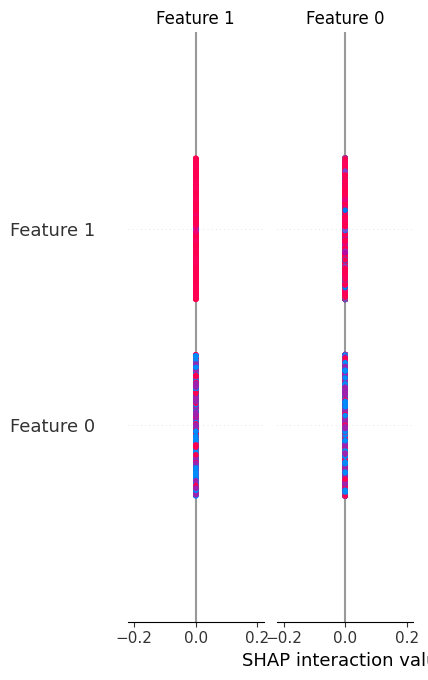

In [6]:
# Calculate SHAP values
shap_values, explainer = suitability_filter.calculate_shap_values()

# To visualize
feature_names = [
    "Mean confidence",
    "Max confidence",
    "Confidence std dev",
    "Confidence entropy",
    "Mean logit",
    "Max logit",
    "Logit std dev",
    "Logit difference top 2",
    "Loss wrt predicted label",
    "Loss difference top 2",
    "Class probability ratio",
    "Sum of top k confidences"
]

shap.summary_plot(shap_values[:, :, 1], suitability_filter.regressor_features, feature_names=feature_names)
shap.dependence_plot("Max logit", shap_values[:, :, 1], suitability_filter.regressor_features, feature_names=feature_names, interaction_index="Logit difference top 2")
shap.decision_plot(explainer.expected_value[1], shap_values[:, :, 1], suitability_filter.regressor_features, feature_names=feature_names)

In [9]:
shap_values.shape

(6562, 12, 2)

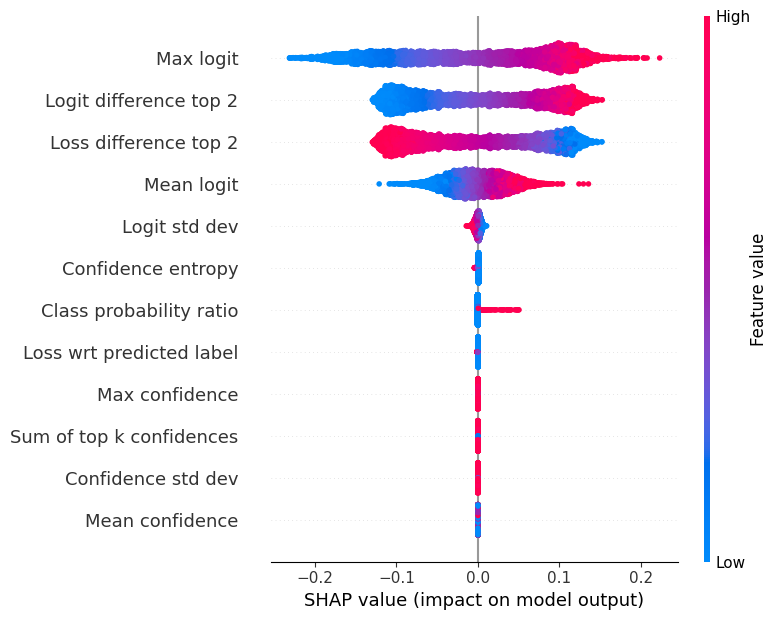

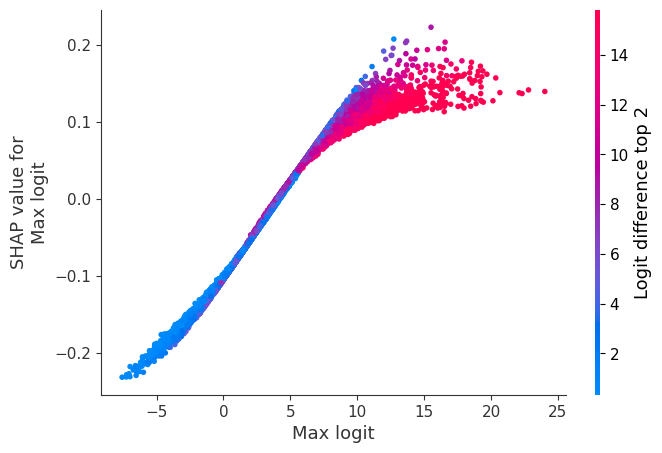

In [ ]:
shap.decision_plot()